In [84]:
from sklearn import datasets

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from math import floor, ceil # for rounding up and down
from scipy.stats import pearsonr

In [2]:
all_data = np.loadtxt(open("./wine_data.csv","r"), delimiter=",", skiprows = 0, dtype=np.float64)

# load class labels from column 1
y_wine = all_data[:,0]
#print (y_wine)
# conversion of the class labels to integer-type array
y_wine = y_wine.astype(np.int64, copy = False)

# load the 14 features
X_wine = all_data[:,1:]

# printing some general information about the data
print('\ntotal number of samples (rows):', X_wine.shape[0])
print('total number of features (columns):', X_wine.shape[1])

# printing the 1st wine sample
float_formatter = lambda x: '{:.2f}'.format(x)
np.set_printoptions(formatter={'float_kind':float_formatter})
print('\n1st sample (i.e., 1st row):\nClass label: {:d}\n{:}\n'
          .format(int(y_wine[0]), X_wine[0]))

# printing the rel.frequency of the class labels
print('Class label frequencies')
print('Class 1 samples: {:.2%}'.format(list(y_wine).count(1)/y_wine.shape[0]))
print('Class 2 samples: {:.2%}'.format(list(y_wine).count(2)/y_wine.shape[0]))
print('Class 3 samples: {:.2%}'.format(list(y_wine).count(3)/y_wine.shape[0]))


total number of samples (rows): 178
total number of features (columns): 13

1st sample (i.e., 1st row):
Class label: 1
[14.23 1.71 2.43 15.60 127.00 2.80 3.06 0.28 2.29 5.64 1.04 3.92 1065.00]

Class label frequencies
Class 1 samples: 33.15%
Class 2 samples: 39.89%
Class 3 samples: 26.97%


In [54]:
''''''
plt.figure(figsize=(10,8))

for label,marker,color in zip(
        range(1,4),('x', 'o', '^'),('blue', 'red', 'green')):

    # Calculate Pearson correlation coefficient
    R = pearsonr(X_wine[:,0][y_wine == label], X_wine[:,1][y_wine == label])
    plt.scatter(x=X_wine[:,0][y_wine == label], # x-axis: feat. from col. 1
                y=X_wine[:,1][y_wine == label], # y-axis: feat. from col. 2
                marker=marker, # data point symbol for the scatter plot
                color=color,
                alpha=0.7,
                label='class {:}, R={:.2f}'.format(label, R[0]) # label for the legend
                )

plt.title('Wine Dataset')
plt.xlabel('alcohol by volume in percent')
plt.ylabel('malic acid in g/l')
plt.legend(loc='upper right')

plt.show()
''''''

NameError: name 'X_wine' is not defined

In [55]:
from mpl_toolkits.mplot3d import Axes3D

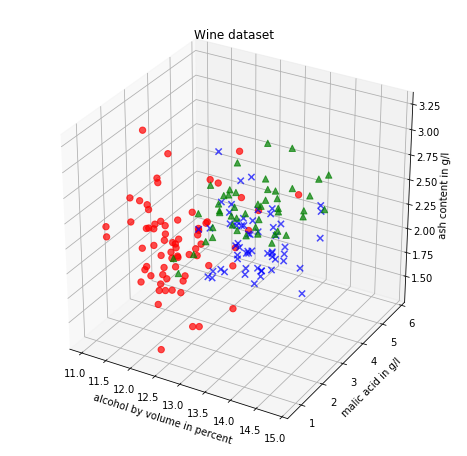

In [90]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

for label,marker,color in zip(
        range(1,4),('x', 'o', '^'),('blue','red','green')):

    ax.scatter(X_wine[:,0][y_wine == label],
               X_wine[:,1][y_wine == label],
               X_wine[:,2][y_wine == label],  
               marker=marker,
               color=color,
               s=40,
               alpha=0.7,
               label='class {}'.format(label))

ax.set_xlabel('alcohol by volume in percent')
ax.set_ylabel('malic acid in g/l')
ax.set_zlabel('ash content in g/l')

plt.title('Wine dataset')

plt.show()

In [91]:
""""""
std_scale = preprocessing.StandardScaler().fit(X_train)
X_train = std_scale.transform(X_train)
X_test = std_scale.transform(X_test)
""""""

''

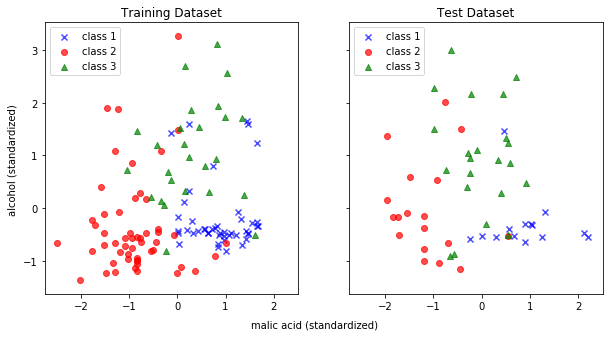

In [42]:
f, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10,5))

for a,x_dat, y_lab in zip(ax, (X_train, X_test), (y_train, y_test)):

    for label,marker,color in zip(
        range(1,4),('x', 'o', '^'),('blue','red','green')):

        a.scatter(x=x_dat[:,0][y_lab == label],
                y=x_dat[:,1][y_lab == label],
                marker=marker,
                color=color,   
                alpha=0.7,   
                label='class {}'.format(label)
                )

    a.legend(loc='upper left')

ax[0].set_title('Training Dataset')
ax[1].set_title('Test Dataset')
f.text(0.5, 0.04, 'malic acid (standardized)', ha='center', va='center')
f.text(0.08, 0.5, 'alcohol (standardized)', ha='center', va='center', rotation='vertical')

plt.show()

In [43]:
minmax_scale = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(X_train)
X_train_minmax = minmax_scale.transform(X_train)
X_test_minmax = minmax_scale.transform(X_test)

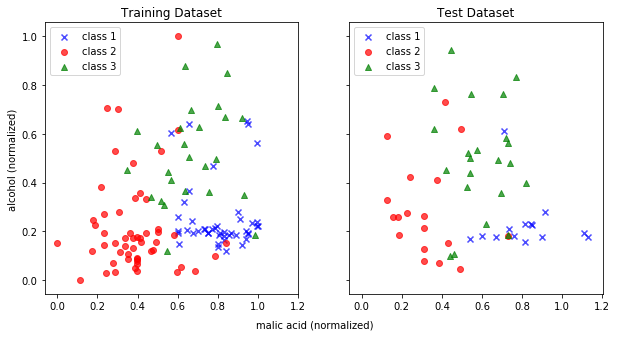

In [44]:
f, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10,5))

for a,x_dat, y_lab in zip(ax, (X_train_minmax, X_test_minmax), (y_train, y_test)):

    for label,marker,color in zip(
        range(1,4),('x', 'o', '^'),('blue','red','green')):

        a.scatter(x=x_dat[:,0][y_lab == label],
                y=x_dat[:,1][y_lab == label],
                marker=marker,
                color=color,   
                alpha=0.7,   
                label='class {}'.format(label)
                )

    a.legend(loc='upper left')

ax[0].set_title('Training Dataset')
ax[1].set_title('Test Dataset')
f.text(0.5, 0.04, 'malic acid (normalized)', ha='center', va='center')
f.text(0.08, 0.5, 'alcohol (normalized)', ha='center', va='center', rotation='vertical')

plt.show()

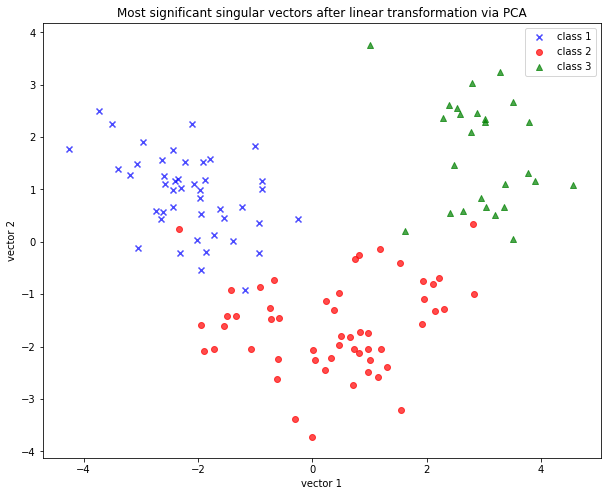

In [92]:
from sklearn.decomposition import PCA
sklearn_pca = PCA(n_components=2) # number of components to keep
sklearn_transf = sklearn_pca.fit_transform(X_train)

plt.figure(figsize=(10,8))

for label,marker,color in zip(
        range(1,4),('x', 'o', '^'),('blue', 'red', 'green')):

    plt.scatter(x=sklearn_transf[:,0][y_train == label],
                y=sklearn_transf[:,1][y_train == label],
                marker=marker,
                color=color,
                alpha=0.7,
                label='class {}'.format(label)
                )

plt.xlabel('vector 1')
plt.ylabel('vector 2')

plt.legend()
plt.title('Most significant singular vectors after linear transformation via PCA')

plt.show()

In [61]:
data = X_wine[:, 5:8]

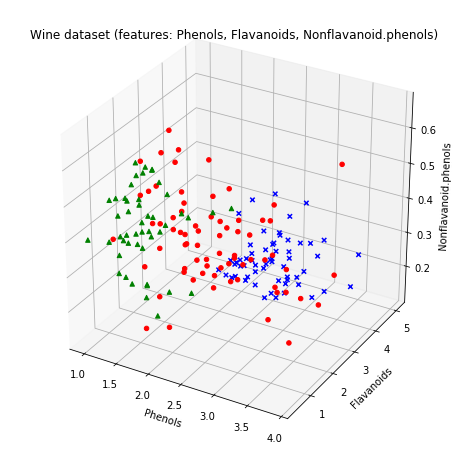

In [83]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111, projection = '3d')
 
for label,marker,color in zip(
        range(1,4),('x', 'o', '^'),('blue','red','green')):

    ax.scatter(data[:,0][y_wine == label],
               data[:,1][y_wine == label],
               data[:,2][y_wine == label],  
               marker = marker,
               color = color,
               s = 20,  # размер точек на графике
               alpha=1.0, # прозрачность точек на графике
               label='class {}'.format(label))

ax.set_xlabel('Phenols')
ax.set_ylabel('Flavanoids')
ax.set_zlabel('Nonflavanoid.phenols')

plt.title('Wine dataset (features: Phenols, Flavanoids, Nonflavanoid.phenols)')

plt.show()

In [21]:
import numpy as np
from matplotlib import pyplot as plt
from math import floor, ceil # for rounding up and down
from scipy.stats import pearsonr
from sklearn import datasets
import pandas as pd
import math

In [22]:
def Get_Class_Label_Of_Object(x):
    return x[len(x)-1]

def Distance(x, y):
    if len(x) != len(y):
        return -1
    
    sum = 0
    for i in range(len(x)):
        sum += (x[i]-y[i])*(x[i]-y[i])
        
    return sum

In [23]:
def PrepareData():
    all_data = np.loadtxt(open("./wine_data.csv","r"), delimiter = ",", skiprows = 0, dtype = np.float64)

    # load class labels from column 1
    y_wine = all_data[:,0]
    #print (y_wine)
    # conversion of the class labels to integer-type array
    y_wine = y_wine.astype(np.int64, copy = False)

    # load the 14 features
    X_wine = all_data[:,1:]
    
    data = all_data[:, 6:9]

    w, h = 4, len(data)
    m = [[0 for x in range(w)] for y in range(h)] 

    for i in range(len(data)):
        for j in range(3):
            m[i][j] = data[i, j]
        m[i][3] = y_wine[i]
    data = m
    return data

data = PrepareData()

def Get_Nearest_Neighbour(x, Omega):
    dist = [0]*len(Omega)
    
    for i in range(len(Omega)):
        dist[i] = Distance(x[0:len(x)-1], Omega[i][0:len(x)-1])
        
    min_dist = min(dist)
    
    for i in range(len(Omega)):
        if dist[i] == min_dist:
            return Omega[i]

In [24]:
def FindEtalon(X, Omega, Xl, defence_to_tolerance_ratio):
    
    Efficiency = [0]*len(X)
    
    for i in range(len(X)):
    
        x = X[i]
    
        sum_of_defence = 0
        label = Get_Class_Label_Of_Object(x)
        cnt_of_objects_of_this_class = 0

        for item in X:
            if Get_Class_Label_Of_Object(item) == label:
                cnt_of_objects_of_this_class = cnt_of_objects_of_this_class + 1

        for item in X: 
            if item != x and Get_Class_Label_Of_Object(item) == label:
                nearest_neighbour_enemy = Get_Nearest_Neighbour(item, Omega)
                S_nom = math.sqrt(Distance(item, x)) - math.sqrt(Distance(item, nearest_neighbour_enemy))
                S_denom = math.sqrt(Distance(item, x)) + math.sqrt(Distance(item, nearest_neighbour_enemy))
                S = S_nom / S_denom
                sum_of_defence += S

        Defence = sum_of_defence / (cnt_of_objects_of_this_class-1)

        Tolerance_sum = 0
        Tolerance_denom = len(Xl) - cnt_of_objects_of_this_class
        
        for item in X: 
            if Get_Class_Label_Of_Object(item) != label:
                S_nom = math.sqrt(Distance(item, x)) - math.sqrt(Distance(item, nearest_neighbour_enemy))
                S_denom = math.sqrt(Distance(item, x)) + math.sqrt(Distance(item, nearest_neighbour_enemy))
                S = S_nom / S_denom
                Tolerance_sum += S

        Tolerance = Tolerance_sum / Tolerance_denom

        Efficiency[i] = defence_to_tolerance_ratio * Defence + (1.0 - defence_to_tolerance_ratio) * Tolerance

    max_Efficiency = max(Efficiency)
    
    for i in range(len(X)):
        if Efficiency[i] == max_Efficiency:
            return X[i]
            
    

In [26]:
def Get_Objects_From_Ith_Class(X, class_label):
    cnt = 0
    
    for i in range(len(X)):
        if X[i][len(X[i])-1] == class_label:
            cnt += 1
    
    w, h = 4, cnt
    res = [[0 for x in range(w)] for y in range(h)] 
    
    cnt = 0
    
    for i in range(len(X)):
        if X[i][len(X[i])-1] == class_label:
            res[cnt] = X[i]
            cnt += 1
    
    return res

def Get_Enemies_Of_Ith_Class(X, class_label):
    cnt = 0
    
    for i in range(len(X)):
        if X[i][len(X[i])-1] != class_label:
          #  res[cnt] = X[i]
            cnt += 1
      
    w, h = 4, cnt
    res = [[0 for x in range(w)] for y in range(h)] 
    
    cnt = 0
    
    for i in range(len(X)):
        if X[i][len(X[i])-1] != class_label:
            res[cnt] = X[i]
            cnt += 1
    
    return res

Etalons_for_class_1 = []
Etalons_for_class_2 = []
Etalons_for_class_3 = []

Xl = data

number_of_classes = 3
for i in range(3):
    Xy = Get_Objects_From_Ith_Class(data, i+1)
    X_enemies = Get_Enemies_Of_Ith_Class(data, i+1)
   
    if i == 0:
        Etalons_for_class_1[len(Etalons_for_class_1):] = [FindEtalon(Xy, X_enemies, Xl, 0.5)]

    if i == 1:
        Etalons_for_class_2[len(Etalons_for_class_2):] = [FindEtalon(Xy, X_enemies, Xl, 0.5)]

    if i == 2:
        Etalons_for_class_3[len(Etalons_for_class_3):] = [FindEtalon(Xy, X_enemies, Xl, 0.5)]


for i in range(3):
    Xy = Get_Objects_From_Ith_Class(data, i+1)
    
    if i == 0:
    if i == 1:
    if i == 2:
        

[[3.8799999999999999, 3.7400000000000002, 0.32000000000000001, 1]]
